/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75646D+00    |proj g|=  9.88789D-01

At iterate    1    f=  1.40749D+00    |proj g|=  4.95414D-01

At iterate    2    f=  1.40400D+00    |proj g|=  4.08924D-01

At iterate    3    f=  1.38168D+00    |proj g|=  1.64723D-01

At iterate    4    f=  1.37629D+00    |proj g|=  1.54585D-01

At iterate    5    f=  1.36882D+00    |proj g|=  1.29082D-01

At iterate    6    f=  1.36115D+00    |proj g|=  5.40819D-02

At iterate    7    f=  1.36043D+00    |proj g|=  5.54523D-02

At iterate    8    f=  1.35968D+00    |proj g|=  1.89490D-01

At iterate    9    f=  1.35779D+00    |proj g|=  1.02176D-01

At iterate   10    f=  1.35635D+00    |proj g|=  9.11689D-02

At iterate   11    f=  1.35370D+00    |proj g|=  1.11061D-01

At iterate   12    f=  1.35365D+00    |proj g|=  7.09776D-02

At iterate   13    f=  1.3

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 3180, number of used features: 1
[LightGBM] [Info] Start training from score 8.374731


15:03:43 - cmdstanpy - INFO - Chain [1] start processing
15:03:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Accuracy - Adaboost: 79.62926759302519 %
Accuracy - ETS: 88.29191768751767 %
Accuracy - SARIMA: 79.79705703599029 %
Accuracy - LightGBM: 79.71606767200849 %
Accuracy - Prophet: 97.26339536251629 %


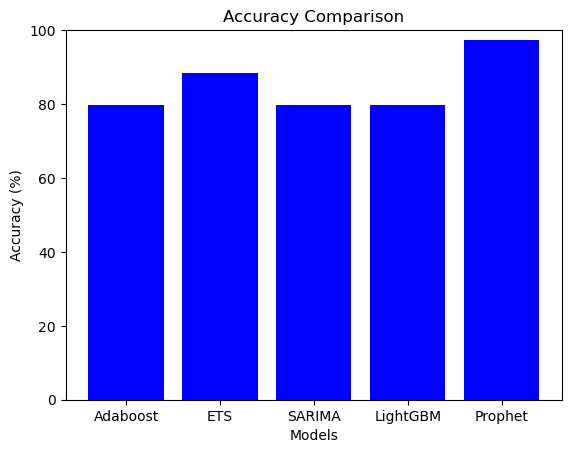

In [9]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load your data into a DataFrame
data = pd.read_csv('GlobalTemperatures.csv')  # Replace with the correct file path

# Drop rows with missing values
data = data.dropna(subset=['LandAverageTemperature'])

# Rename columns to match Prophet's expectations
data.rename(columns={'dt': 'ds', 'LandAverageTemperature': 'y'}, inplace=True)

# Initialize the models
adaboost_model = AdaBoostRegressor(n_estimators=100, random_state=0)
ets_model = ETSModel(data['y'], error='add', trend='add', seasonal='add', seasonal_periods=12)
sarima_model = SARIMAX(data['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
lgbm_model = LGBMRegressor()

# Fit the models
adaboost_model.fit(data.index.values.reshape(-1, 1), data['y'])
ets_fit = ets_model.fit()
sarima_fit = sarima_model.fit(disp=False)
lgbm_model.fit(data.index.values.reshape(-1, 1), data['y'])

# Initialize the Prophet model
prophet_model = Prophet(yearly_seasonality=True)

# Fit the Prophet model to the data
prophet_model.fit(data)

# Create a future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=12, freq='M')  # Adjust the periods as needed

# Make predictions with all models
adaboost_pred = adaboost_model.predict(data.index.values.reshape(-1, 1))
ets_pred = ets_fit.forecast(steps=len(data))
sarima_pred = sarima_fit.get_forecast(steps=len(data)).predicted_mean
lgbm_pred = lgbm_model.predict(data.index.values.reshape(-1, 1))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast['yhat'][:-12]  # Exclude the forecasted values for future dates

# Calculate Mean Absolute Error for all models
mae_adaboost = mean_absolute_error(data['y'], adaboost_pred)
mae_ets = mean_absolute_error(data['y'], ets_pred)
mae_sarima = mean_absolute_error(data['y'], sarima_pred)
mae_lgbm = mean_absolute_error(data['y'], lgbm_pred)
mae_prophet = mean_absolute_error(data['y'], prophet_pred)

# Calculate the accuracy in percentage (normalized to 0-100%)
max_value = max(data['y'])
accuracy_adaboost = (1 - mae_adaboost / max_value) * 100
accuracy_ets = (1 - mae_ets / max_value) * 100
accuracy_sarima = (1 - mae_sarima / max_value) * 100
accuracy_lgbm = (1 - mae_lgbm / max_value) * 100
accuracy_prophet = (1 - mae_prophet / max_value) * 100

# Print accuracy for all models
print("Accuracy - Adaboost:", accuracy_adaboost, "%")
print("Accuracy - ETS:", accuracy_ets, "%")
print("Accuracy - SARIMA:", accuracy_sarima, "%")
print("Accuracy - LightGBM:", accuracy_lgbm, "%")
print("Accuracy - Prophet:", accuracy_prophet, "%")

# Visualization
models = ['Adaboost', 'ETS', 'SARIMA', 'LightGBM', 'Prophet']
accuracy_scores = [accuracy_adaboost, accuracy_ets, accuracy_sarima, accuracy_lgbm, accuracy_prophet]

plt.bar(models, accuracy_scores, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.ylim(0, 100)  # Set y-axis limit to 0-100%
plt.show()


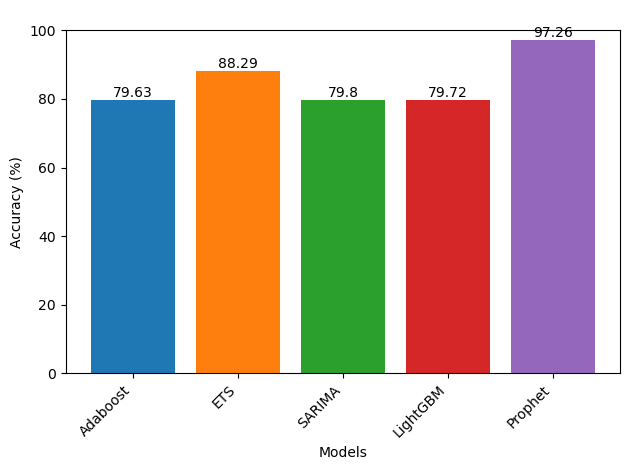

In [4]:
import matplotlib.pyplot as plt

models = ['Adaboost', 'ETS', 'SARIMA', 'LightGBM', 'Prophet']
accuracy_scores = [79.63, 88.29, 79.80, 79.72, 97.26]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a figure and axis
fig, ax = plt.subplots()

# Set the colors for each bar
bars = ax.bar(models, accuracy_scores, color=colors)

# Set the title and labels
ax.set_title(' ')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha="right")

# Set the y-axis limits to focus on the data
plt.ylim(0, 100)

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')
plt.savefig('landavgtemp.eps', format='eps', bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()

# Export the plot as an EPS file



/tmp/ipykernel_918463/2964800166.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(models))


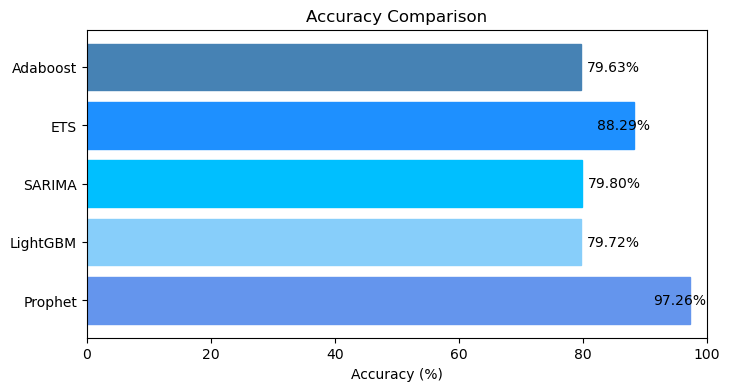

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Adaboost', 'ETS', 'SARIMA', 'LightGBM', 'Prophet']
accuracy_scores = [79.63, 88.29, 79.80, 79.72, 97.26]

# Create a horizontal bar plot
plt.figure(figsize=(8, 4))  # Set the figure size

# Choose distinct colors for bars
colors = ['steelblue', 'dodgerblue', 'deepskyblue', 'lightskyblue', 'cornflowerblue']

# Create a colormap for the bars
cmap = plt.cm.get_cmap('coolwarm', len(models))

# Plot the bars
bars = plt.barh(models, accuracy_scores, color=colors)

# Customize the appearance of the bars
for bar, color in zip(bars, colors):
    bar.set_color(color)
    width = bar.get_width()
    if width < 80:
        plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center', color='black')
    else:
        plt.text(width - 6, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center', color='black')

plt.xlabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.xlim(0, 100)  # Set x-axis limit to 0-100%
plt.gca().invert_yaxis()  # Invert y-axis to have Adaboost at the top

# Export the plot as an EPS file
plt.savefig('landavgtemp.eps', format='eps', bbox_inches='tight')

# Show the plot
plt.show()
